In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# visualization, graph
from matplotlib import pyplot as plt
import matplotlib.patches as patches
import matplotlib
import seaborn as sns
plt.style.use('seaborn')
sns.set(style='white', context='notebook', palette='deep', font_scale=1.5)
%matplotlib inline

#ignore warnings
import warnings
warnings.filterwarnings('ignore')

import json
import os
print(os.listdir('/kaggle/input/understanding_cloud_organization/'))

from glob import glob
from tqdm import tqdm

['test_images', 'train.csv', 'train_images', 'sample_submission.csv']


In [2]:
!pip install segmentation-models --quiet

In [3]:
import albumentations as albu
import keras
from keras import backend as K
from keras.models import Model
from keras.layers import Input
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.losses import binary_crossentropy
from keras.optimizers import Adam, Nadam
from keras.callbacks import Callback, ModelCheckpoint
from sklearn.model_selection import train_test_split
import segmentation_models as sm

Using TensorFlow backend.


Segmentation Models: using `keras` framework.


# Preprocessing

In [4]:
test_Path = '/kaggle/input/understanding_cloud_organization/test_images'
train_Path = '/kaggle/input/understanding_cloud_organization/train_images'
print('Test image num', len(os.listdir(test_Path)))
print('Train image num', len(os.listdir(train_Path)))

Test image num 3698
Train image num 5546


In [5]:
train_df = pd.read_csv('/kaggle/input/understanding_cloud_organization/train.csv')
train_df.head()

,Image_Label,EncodedPixels
0,0011165.jpg_Fish,264918 937 266318 937 267718 937 269118 937 27...
1,0011165.jpg_Flower,1355565 1002 1356965 1002 1358365 1002 1359765...
2,0011165.jpg_Gravel,NaN
3,0011165.jpg_Sugar,NaN
4,002be4f.jpg_Fish,233813 878 235213 878 236613 878 238010 881 23...


In [6]:
# split label
train_df['ImageId'] = train_df['Image_Label'].str.split('_').agg(lambda x: x[0])
train_df['Label'] = train_df['Image_Label'].str.split('_').agg(lambda x: x[1])
train_df.head(10)

,Image_Label,EncodedPixels,ImageId,Label
0,0011165.jpg_Fish,264918 937 266318 937 267718 937 269118 937 27...,0011165.jpg,Fish
1,0011165.jpg_Flower,1355565 1002 1356965 1002 1358365 1002 1359765...,0011165.jpg,Flower
2,0011165.jpg_Gravel,NaN,0011165.jpg,Gravel
3,0011165.jpg_Sugar,NaN,0011165.jpg,Sugar
4,002be4f.jpg_Fish,233813 878 235213 878 236613 878 238010 881 23...,002be4f.jpg,Fish
5,002be4f.jpg_Flower,1339279 519 1340679 519 1342079 519 1343479 51...,002be4f.jpg,Flower
6,002be4f.jpg_Gravel,NaN,002be4f.jpg,Gravel
7,002be4f.jpg_Sugar,67495 350 68895 350 70295 350 71695 350 73095 ...,002be4f.jpg,Sugar
8,0031ae9.jpg_Fish,3510 690 4910 690 6310 690 7710 690 9110 690 1...,0031ae9.jpg,Fish
9,0031ae9.jpg_Flower,2047 703 3447 703 4847 703 6247 703 7647 703 9...,0031ae9.jpg,Flower


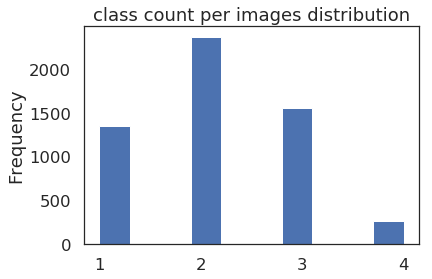

In [7]:
train_df.groupby('ImageId')['EncodedPixels'].count().plot(kind='hist', title='class count per images distribution')

* 클래스가 2개인 영상이 가장 많고 모든 클래스가 다 포함된 영상은 별로 없음.

(-1.1167092209878937,
 1.111167230316861,
 -1.1288767869661804,
 1.1013750850936277)

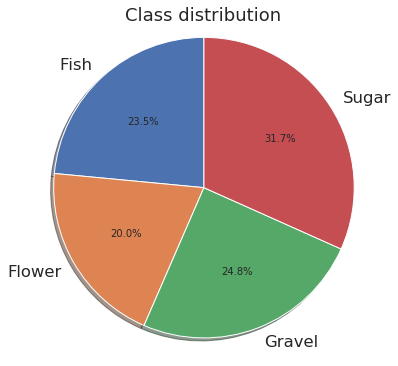

In [8]:
label_list = train_df['Label'].unique().tolist()
label_count = []
for label in label_list:
    label_count.append(train_df.loc[train_df['Label']==label, 'EncodedPixels'].count())

fig, ax = plt.subplots(figsize=(6,6))
ax.pie(label_count, labels=label_list, autopct='%1.1f%%', shadow=True, startangle=90)
ax.set_title('Class distribution')
ax.axis('equal')

* 클래스는 골고루 분포해 보임.

In [9]:
train_df_tmp = train_df.dropna()
train_df_tmp.reset_index(drop=True, inplace=True)
train_df_tmp = train_df_tmp.groupby('ImageId')['Label'].sum()

train_df2 = train_df_tmp.reset_index()

train_df_tmp.head(10)

ImageId
0011165.jpg         FishFlower
002be4f.jpg    FishFlowerSugar
0031ae9.jpg    FishFlowerSugar
0035239.jpg       FlowerGravel
003994e.jpg    FishGravelSugar
00498ec.jpg             Gravel
006bf7c.jpg          FishSugar
006c5a6.jpg          FishSugar
008233e.jpg              Sugar
008a5ff.jpg          FishSugar
Name: Label, dtype: object

Text(0.5, 1.0, 'Class distribution2')

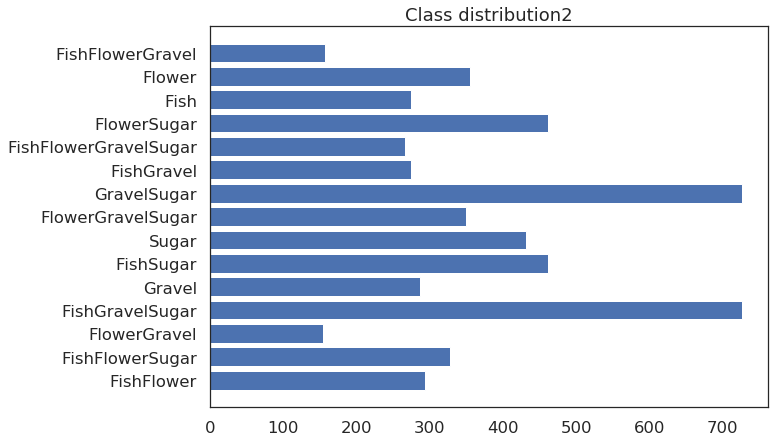

In [10]:
label = train_df_tmp.unique()
label_cnt = np.array([(train_df_tmp[train_df_tmp==ele]).count() for ele in label])
fig, ax = plt.subplots(figsize=(10,7))
ax.barh(label, label_cnt)
ax.set_title('Class distribution2')

In [11]:
# image generator에 사용
train_df['hasMask'] = ~ train_df['EncodedPixels'].isna()
mask_count_df = train_df.groupby('ImageId').agg(np.sum).reset_index()
mask_count_df.sort_values('hasMask', ascending=False, inplace=True)
print(mask_count_df.shape)
mask_count_df.head()

(5546, 2)


,ImageId,hasMask
821,24dd99c.jpg,4.0
1885,562f80a.jpg,4.0
3260,944f10b.jpg,4.0
1872,55b539f.jpg,4.0
4464,cdf7242.jpg,4.0


In [12]:
# test df
sub_df = pd.read_csv('/kaggle/input/understanding_cloud_organization/sample_submission.csv')
sub_df['ImageId'] = sub_df['Image_Label'].apply(lambda x: x.split('_')[0])
test_imgs = pd.DataFrame(sub_df['ImageId'].unique(), columns=['ImageId'])
test_imgs.head()

,ImageId
0,002f507.jpg
1,0035ae9.jpg
2,0038327.jpg
3,004f759.jpg
4,005ba08.jpg


# simple visualization

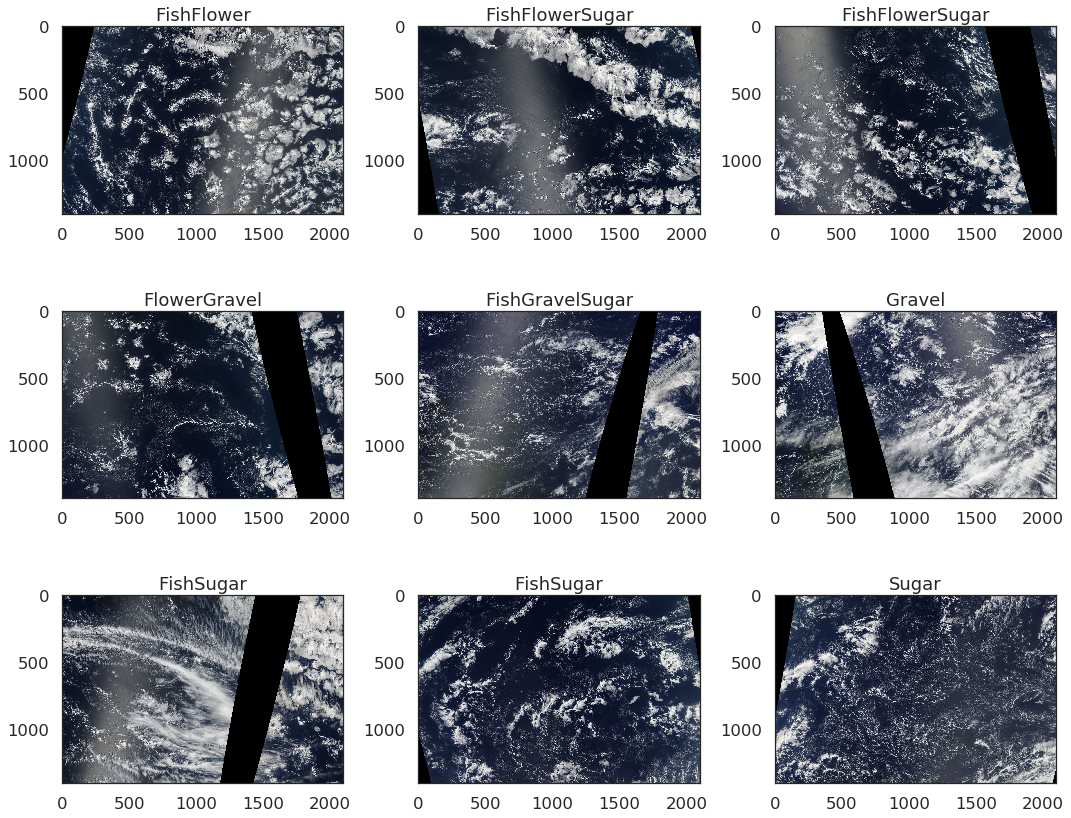

In [13]:
import cv2

def display_samples(path, df, columns=3, rows=3):
    imgid = df['ImageId'].values
    labels = df['Label'].values
    
    fig=plt.figure(figsize=(5*columns, 4*rows))
    for i in range(columns*rows): 
        img = cv2.imread(os.path.join(path, f'{imgid[i]}'))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        label = labels[i]

        fig.add_subplot(rows, columns, i+1)
        plt.title(label)
        plt.imshow(img)

    plt.tight_layout()

display_samples(train_Path, train_df2)

resize, mask to rle, rle to mask

In [14]:
def np_resize(img, input_shape):
    height, width = input_shape
    return cv2.resize(img, (width, height))
    
def mask2rle(img):
    pixels= img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def rle2mask(rle, input_shape):
    width, height = input_shape[:2]
    
    mask = np.zeros( width*height ).astype(np.uint8)
    
    array = np.asarray([int(x) for x in rle.split()])
    starts = array[0::2]
    lengths = array[1::2]

    current_position = 0
    for index, start in enumerate(starts):
        mask[int(start):int(start+lengths[index])] = 1
        current_position += lengths[index]
        
    return mask.reshape(height, width).T

def build_masks(rles, input_shape, reshape=None):
    depth = len(rles)
    if reshape is None:
        masks = np.zeros((*input_shape, depth))
    else:
        masks = np.zeros((*reshape, depth))
    
    for i, rle in enumerate(rles):
        if type(rle) is str:
            if reshape is None:
                masks[:, :, i] = rle2mask(rle, input_shape)
            else:
                mask = rle2mask(rle, input_shape)
                reshaped_mask = np_resize(mask, reshape)
                masks[:, :, i] = reshaped_mask
    
    return masks

def build_rles(masks, reshape=None):
    width, height, depth = masks.shape
    
    rles = []
    
    for i in range(depth):
        mask = masks[:, :, i]
        
        if reshape:
            mask = mask.astype(np.float32)
            mask = np_resize(mask, reshape).astype(np.int64)
        
        rle = mask2rle(mask)
        rles.append(rle)
        
    return rles

영상에 mask(class 영역) 표시

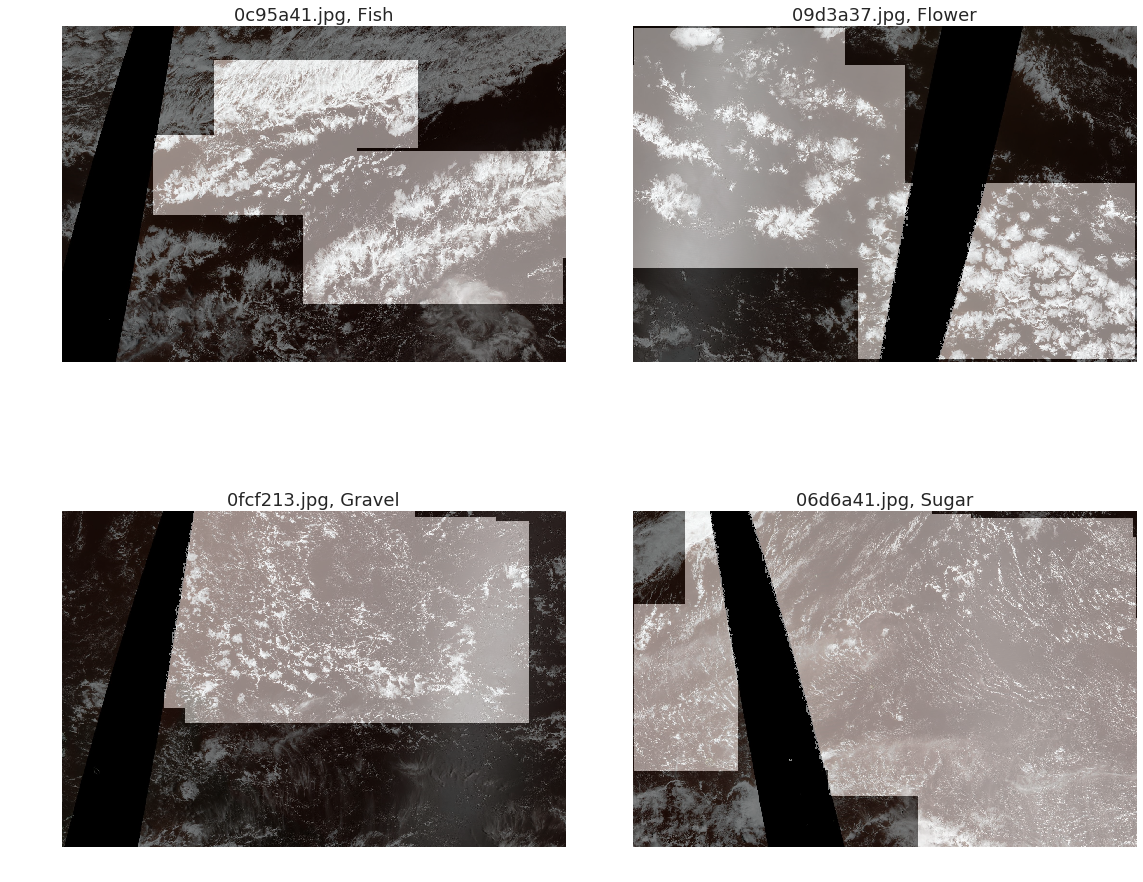

In [15]:
labels = train_df['Label'].unique()

columns, rows = 2, 2
fig=plt.figure(figsize=(8*columns, 7*rows))
for i in range(columns*rows): 
    
    label = labels[i]
    img_id = train_df_tmp.iloc[np.where(train_df_tmp==label)].index[10]
    
    seg_img = cv2.imread(os.path.join(train_Path, img_id))
    
    rle = train_df.loc[(train_df['ImageId']==img_id) & (train_df['Label']==label), 'EncodedPixels'].values[0]
    mask = rle2mask(rle, seg_img.shape)
    
    fig.add_subplot(rows, columns, i+1)
    plt.axis('off')
    plt.title(f'{img_id}, {label}')
    plt.imshow(seg_img)
    plt.imshow(mask, alpha=0.5, cmap='gray')

plt.tight_layout()

# Image Generator

In [16]:
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, df, target_df=None, mode='fit',
                 base_path=train_Path,
                 batch_size=32, dim=(1400, 2100), n_channels=3, reshape=None,
                 augment=False, n_classes=4, random_state=2019, shuffle=True):
        self.dim = dim
        self.batch_size = batch_size
        self.df = df
        self.mode = mode
        self.base_path = base_path
        self.target_df = target_df
        self.list_IDs = list_IDs
        self.reshape = reshape
        self.n_channels = n_channels
        self.augment = augment
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.random_state = random_state
        
        self.on_epoch_end()
        np.random.seed(self.random_state)

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_batch = [self.list_IDs[k] for k in indexes]
        
        X = self.__generate_X(list_IDs_batch)
        
        if self.mode == 'fit':
            y = self.__generate_y(list_IDs_batch)
            
            if self.augment:
                X, y = self.__augment_batch(X, y)
            
            return X, y
        
        elif self.mode == 'predict':
            return X

        else:
            raise AttributeError('The mode parameter should be set to "fit" or "predict".')
        
    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.seed(self.random_state)
            np.random.shuffle(self.indexes)
    
    def __generate_X(self, list_IDs_batch):
        'Generates data containing batch_size samples'
        # Initialization
        if self.reshape is None:
            X = np.empty((self.batch_size, *self.dim, self.n_channels))
        else:
            X = np.empty((self.batch_size, *self.reshape, self.n_channels))
        
        # Generate data
        for i, ID in enumerate(list_IDs_batch):
            im_name = self.df['ImageId'].iloc[ID]
            img_path = f"{self.base_path}/{im_name}"
            img = self.__load_rgb(img_path)
            
            if self.reshape is not None:
                img = np_resize(img, self.reshape)
            
            # Store samples
            X[i,] = img

        return X
    
    # 압축된 픽셀 정보 복원.
    def __generate_y(self, list_IDs_batch):
        if self.reshape is None:
            y = np.empty((self.batch_size, *self.dim, self.n_classes), dtype=int)
        else:
            y = np.empty((self.batch_size, *self.reshape, self.n_classes), dtype=int)
        
        for i, ID in enumerate(list_IDs_batch):
            im_name = self.df['ImageId'].iloc[ID]
            image_df = self.target_df[self.target_df['ImageId'] == im_name]
            
            rles = image_df['EncodedPixels'].values
            
            if self.reshape is not None:
                masks = build_masks(rles, input_shape=self.dim, reshape=self.reshape)
            else:
                masks = build_masks(rles, input_shape=self.dim)
            
            y[i, ] = masks

        return y
    
    def __load_grayscale(self, img_path):
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = img.astype(np.float32) / 255.
        img = np.expand_dims(img, axis=-1)

        return img
    
    def __load_rgb(self, img_path):
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = img.astype(np.float32) / 255.

        return img
    
    def __random_transform(self, img, masks):
        composition = albu.Compose([
            albu.HorizontalFlip(),
            albu.VerticalFlip(),
            albu.ShiftScaleRotate(rotate_limit=45, shift_limit=0.15, scale_limit=0.15)
        ])
        
        composed = composition(image=img, mask=masks)
        aug_img = composed['image']
        aug_masks = composed['mask']
        
        return aug_img, aug_masks
    
    def __augment_batch(self, img_batch, masks_batch):
        for i in range(img_batch.shape[0]):
            img_batch[i, ], masks_batch[i, ] = self.__random_transform(
                img_batch[i, ], masks_batch[i, ])
        
        return img_batch, masks_batch

In [17]:
BATCH_SIZE = 32

train_idx, val_idx = train_test_split(
    mask_count_df.index, random_state=2019, test_size=0.2
)

train_generator = DataGenerator(
    train_idx, 
    df=mask_count_df,
    target_df=train_df,
    batch_size=BATCH_SIZE,
    reshape=(320, 480),
    augment=True,
    n_channels=3,
    n_classes=4
)

val_generator = DataGenerator(
    val_idx, 
    df=mask_count_df,
    target_df=train_df,
    batch_size=BATCH_SIZE, 
    reshape=(320, 480),
    augment=False,
    n_channels=3,
    n_classes=4
)

# Modeling

In [18]:
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

In [19]:
model = sm.Unet(
    'resnet34', 
    classes=4,
    input_shape=(320, 480, 3),
    activation='sigmoid'
)
model.compile(optimizer=Nadam(lr=0.0002), loss=bce_dice_loss, metrics=[dice_coef])
# model.summary()

85524480/85521592 [==============================] - 2s 0us/step


# Learning

In [20]:
checkpoint = ModelCheckpoint('smodel.h5', save_best_only=True)

mhistory = model.fit_generator(
    train_generator,
    validation_data=val_generator,
    callbacks=[checkpoint],
    epochs=25
)

Epoch 1/25
138/138 [==============================] - 653s 5s/step - loss: 1.1340 - dice_coef: 0.3500 - val_loss: 1.2546 - val_dice_coef: 0.1798
Epoch 2/25
138/138 [==============================] - 599s 4s/step - loss: 0.8967 - dice_coef: 0.4364 - val_loss: 1.5302 - val_dice_coef: 0.1978
Epoch 3/25
138/138 [==============================] - 583s 4s/step - loss: 0.8356 - dice_coef: 0.4786 - val_loss: 1.4030 - val_dice_coef: 0.1047
Epoch 4/25
138/138 [==============================] - 590s 4s/step - loss: 0.8090 - dice_coef: 0.5016 - val_loss: 2.1693 - val_dice_coef: 0.2074
Epoch 5/25
138/138 [==============================] - 580s 4s/step - loss: 0.7918 - dice_coef: 0.5146 - val_loss: 2.0543 - val_dice_coef: 0.2068
Epoch 6/25
138/138 [==============================] - 593s 4s/step - loss: 0.7773 - dice_coef: 0.5266 - val_loss: 1.9369 - val_dice_coef: 0.2307
Epoch 7/25
138/138 [==============================] - 582s 4s/step - loss: 0.7697 - dice_coef: 0.5329 - val_loss: 2.3438 - val_dic

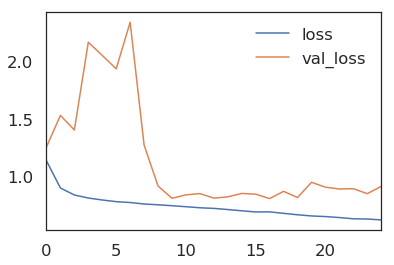

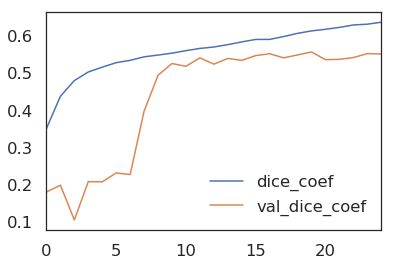

In [21]:
# with open('history.json', 'w') as f:
#     json.dump(mhistory.history, f)

history_df = pd.DataFrame(mhistory.history)
history_df[['loss', 'val_loss']].plot()
history_df[['dice_coef', 'val_dice_coef']].plot()

# Prediction & Submission

In [22]:
model.load_weights('smodel.h5')
test_df = []

for i in range(0, test_imgs.shape[0], 500):
    batch_idx = list(
        range(i, min(test_imgs.shape[0], i + 500))
    )

    test_generator = DataGenerator(
        batch_idx,
        df=test_imgs,
        shuffle=False,
        mode='predict',
        dim=(350, 525),
        reshape=(320, 480),
        n_channels=3,
        base_path=test_Path,
        target_df=sub_df,
        batch_size=1,
        n_classes=4
    )

    batch_pred_masks = model.predict_generator(
        test_generator, 
        workers=1,
        verbose=1
    )

    # mask to rle
    for j, b in enumerate(batch_idx):
        filename = test_imgs['ImageId'].iloc[b]
        image_df = sub_df[sub_df['ImageId'] == filename].copy()

        pred_masks = batch_pred_masks[j, ].round().astype(int)
        pred_rles = build_rles(pred_masks, reshape=(350, 525))

        image_df['EncodedPixels'] = pred_rles
        test_df.append(image_df)

198/198 [==============================] - 13s 66ms/step


In [23]:
test_df = pd.concat(test_df)
test_df.drop(columns='ImageId', inplace=True)
test_df.to_csv('submission.csv', index=False)